# 1 导入库

In [1]:
from in_scope_filter.in_scope_filter import In_Scope_Filter
from exp_rot_nets.expand_network import Expand_Network
from exp_rot_nets.rollout_network import Rollout_Network
from reaction import remove_mapped_num, single_step_synthesis, Reaction
import pandas as pd
from rdkit import Chem
import numpy as np
from sklearn.preprocessing import LabelEncoder
from MCTS.mcts_node import MCTSNode, State
from MCTS.mcts_policy import MCTS_Policy_old
from rdkit.Chem.Draw import IPythonConsole
from MCTS.Retrosynthetic import Retrosynthetic

/home/stein/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 2. 导入相关参数和模型

### 2.1 导入蒙特卡洛树搜索超参数（到时候可以进入hyperparams.py修改， 调参）

In [2]:
from hyperparams import Hyperparams as hp

In [5]:
hp.max_game_length #最大变换次数， 超过这个次数自动停止MCTS

5

### 2.2 导入 In scope filter network,  目前为止还没有作用，未来工作可以将它和expand network整合成 pipeline

In [6]:
isf = In_Scope_Filter(model_path = "in_scope_filter/in_scope_filter_model/in_scope_filter.h5")

/home/stein/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:198: UserWarning: The `Highway` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `Highway` layer is deprecated '
/home/stein/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


### 2.3 导入 扩展策略网络

In [7]:
exp = Expand_Network(n_classes=10, n_feats=10000, model_path="exp_rot_nets/expnet_model/expnet.h5")

/home/stein/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:198: UserWarning: The `Highway` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `Highway` layer is deprecated '
/home/stein/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


### 2.4 导入 rollout  网路 目前没用

In [8]:
rot = Rollout_Network(n_classes=10, n_feats=10000, model_path="exp_rot_nets/rotnet_model/rotnet.h5")

/home/stein/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


### 2.5 导入扩展策略网络和rollout网路 对应的分子指纹 特征的列  （加和最大的前一万个列）

In [13]:
exp_indexes = np.load("exp_rot_nets/expnet_model/top_10000_indexes.npy")
rot_indexes = np.load("exp_rot_nets/rotnet_model/top_10000_indexes.npy")

In [14]:
from utils import get_product_fingerprint, get_topk_transformation_v2

### 2.6 导入label encoder, label encoder 将化学反应中心编码为数字

In [15]:
lbl2 = LabelEncoder()
lbl2.classes_ = np.load("exp_rot_nets/expnet_model/expnet_relabel.npy")
lbl1 = LabelEncoder()
lbl1.classes_ = np.load("exp_rot_nets/useful_data/expand_rule_label_encoder.npy")

# 3 DEMO

### 3.1 定义用来进行MCTS的分子

In [16]:
smarts = np.load("useful_smarts_pos_0.npy")

In [19]:
product_smile1 = smarts[5].split(">>")[-1]
product_smile2 = smarts[1].split(">>")[-1]
mol1 = Chem.MolFromSmiles(product_smile1)
mol2 = Chem.MolFromSmiles(product_smile2)

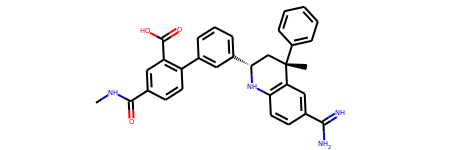

In [20]:
mol1

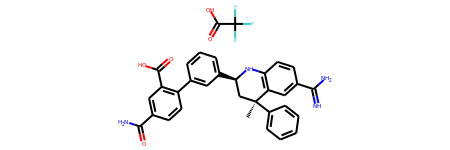

In [21]:
mol2

#### MCTS初始搜索状态 即只包含 mol1和mol2作为初始分子

In [33]:
init_state = State([product_smile1,product_smile2])

### 3.2 定义 building block mols

In [24]:
build_block_mols = ["a", 'b', 'c', "CCCC1(CC(Nc2ccc(cc21)C(=N)N)c1cccc(c1)-c1ccc(cc1C(=O)O)CO)c1ccccc1"]

### 3.2 MCTS（开始搜索了）

In [26]:
Searcher, moves, associated_mols = Retrosynthetic(exp, isf, init_state, lbl1, lbl2, exp_indexes, build_block_mols, parallel_readouts=5, num_readouts=6, verbosity=0)

/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol CNC(=O)C1=CC(C(O)=O)=C(C=C1)C1=CC(=CC=C1)[C@@H]1C[C@](C)(C2=CC=CC=C2)C2=C(N1)C=CC(=C2)C(N)=N
transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol CNC(=O)C1=CC(C(O)=O)=C(C=C1)C1=CC(=CC=C1)[C@@H]1C[C@](C)(C2=CC=CC=C2)C2=C(N1)C=CC(=C2)C(N)=N
transformation [S&H1:2].[S&H1:1]>>[S:2]-,:[S:1] target_mol OC(=O)C(F)(F)F.C[C@@]1(C[C@H](NC2=C1C=C(C=C2)C(N)=N)C1=CC=CC(=C1)C1=C(C=C(C=C1)C(N)=O)C(O)=O)C1=CC=CC=C1


/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol OC(=O)C(F)(F)F.C[C@@]1(C[C@H](NC2=C1C=C(C=C2)C(N)=N)C1=CC=CC(=C1)C1=C(C=C(C=C1)C(N)=O)C(O)=O)C1=CC=CC=C1
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol OC(=O)C(F)(F)F.C[C@@]1(C[C@H](NC2=C1C=C(C=C2)C(N)=N)C1=CC=CC(=C1)C1=C(C=C(C=C1)C(N)=O)C(O)=O)C1=CC=CC=C1
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol CNC(=O)C1=CC(C(O)=O)=C(C=C1)C1=CC(=CC=C1)[C@@H]1C[C@](C)(C2=CC=CC=C2)C2=C(N1)C=CC(=C2)C(N)=N
transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol OC(=O)C(F)(F)F.C[C@@]1(C[C@H](NC2=C1C=C(C=C2)C(N)=N)C1=CC=CC(=C1)C1=C(C=C(C=C1)C(N)=O)C(O)=O)C1=CC=CC=C1
transformation [S&H1:2].[S&H1:1]>>[S:2]-,:[S:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O


/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol CC1(CC(Nc2ccc(cc21)C(=N)N)c1cccc(c1)-c1ccc(cc1C(=O)O)C([NH])=O)c1ccccc1
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol OC(=O)C(F)(F)F.C[C@@]1(C[C@H](NC2=C1C=C(C=C2)C(N)=N)C1=CC=CC(=C1)C1=C(C=C(C=C1)C(N)=O)C(O)=O)C1=CC=CC=C1
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol OC(=O)C(F)(F)F.C[C@@]1(C[C@H](NC2=C1C=C(C=C2)C(N)=N)C1=CC=CC(=C1)C1=C(C=C(C=C1)C(N)=O)C(O)=O)C1=CC=CC=C1


/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol [CH]
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol [CH]
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O


/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol [CH]
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol [CH]
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol [CH]
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3[CH]c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol [CH]


/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [S&H1:2].[S&H1:1]>>[S:2]-,:[S:1] target_mol [CH]
transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol [CH]
transformation [S&H1:2].[S&H1:1]>>[S:2]-,:[S:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3[CH]c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol [CH]


/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

transformation [S&H1:1].[S&H1:2]>>[S:1]-,:[S:2] target_mol OC(=O)C(F)(F)F.C[C@@]1(C[C@H](NC2=C1C=C(C=C2)C(N)=N)C1=CC=CC(=C1)C1=C(C=C(C=C1)C(N)=O)C(O)=O)C1=CC=CC=C1
transformation [N:1]-,:[C:2]>>[N&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol [CH]
transformation [S&H1:2].[S&H1:1]>>[S:2]-,:[S:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O


/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol CC(c1ccccc1)c1cc(ccc1N[CH]c1cccc(c1)-c1ccc(cc1C(=O)O)C([NH])=O)C(=N)N
transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol [CH]
transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol [CH]
transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3[CH]c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [S&H1:1].[S&H1:2]>>[S:1]-,:[S:2] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [N:1]-,:[C:2]>>[N&H1:1] target_mol [CH]


/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

transformation [S&H1:2].[S&H1:1]>>[S:2]-,:[S:1] target_mol [CH]
transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol [CH]
transformation [S&H1:1].[S&H1:2]>>[S:1]-,:[S:2] target_mol [CH]


/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

transformation [C:1]=[O:2]>>[C&H2:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N
transformation [N:1]-,:[C:2]>>[N&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [S:1]=[O:2]>>[S:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N
transformation [C:1]=[O:2]>>[C&H2:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3[CH]c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [N:1]-,:[C:2]>>[N&H1:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N


/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N
transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N
transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3[CH]c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [S:1]=[O:2]>>[S:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3[CH]c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [C:1]=[O:2]>>[C&H2:1] target_mol [CH]
transformation [N:1]-,:[C:2]>>[N&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3[CH]c3ccccc3)C(=N)N)c2)c(c1)C(=O)O
transformation [S:1]=[O:2]>>[S:1] target_mol [CH]


/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O


/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

transformation [C:1]=[O:2]>>[C&H2:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N
transformation [S:1]=[O:2]>>[S:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N
transformation [C&H1:1]-,:[C:2]>>[C&H2:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N


/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

transformation [C:1]=[O:2]>>[C&H2:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N
transformation [C:1]=[O:2]>>[C&H2:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N
transformation [C:1]=[O:2]>>[C&H2:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N
transformation [S:1]=[O:2]>>[S:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N
transformation [C&H1:1]-,:[C:2]>>[C&H2:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N


/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/stein/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

#### 3.2.1从根节点开始的对应变换

In [27]:
moves

['[C:1]-,:[C:2]>>[C&H1:1]',
 '[C:2]-,:[N:1]>>[N&H1:1]',
 '[C:2]-,:[N:1]>>[N&H1:1]',
 '[C:1]=[O:2]>>[C&H2:1]',
 '[C:1]=[O:2]>>[C&H2:1]']

#### 3.2.2上面的每一个对应变换所涉及的分子index 

In [28]:
associated_mols

[0, 1, 0, 0, 0]

### 初始状态的分子

In [38]:
init_state.mols

['CNC(=O)C1=CC(C(O)=O)=C(C=C1)C1=CC(=CC=C1)[C@@H]1C[C@](C)(C2=CC=CC=C2)C2=C(N1)C=CC(=C2)C(N)=N',
 'OC(=O)C(F)(F)F.C[C@@]1(C[C@H](NC2=C1C=C(C=C2)C(N)=N)C1=CC=CC(=C1)C1=C(C=C(C=C1)C(N)=O)C(O)=O)C1=CC=CC=C1']

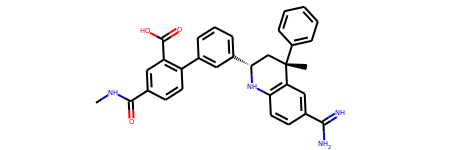

In [39]:
mol1

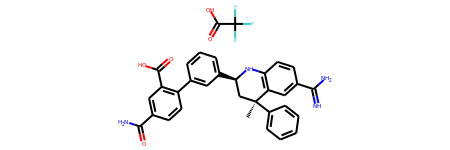

In [40]:
mol2

### 看看第一个变换 '[C:1]-,:[C:2]>>[C&H1:1]' ， 这个变换作用在第0号分子上

In [41]:
hh1 = init_state.transform(transformation="[C:1]-,:[C:2]>>[C&H1:1]", index=0)

transformation [C:1]-,:[C:2]>>[C&H1:1] target_mol CNC(=O)C1=CC(C(O)=O)=C(C=C1)C1=CC(=CC=C1)[C@@H]1C[C@](C)(C2=CC=CC=C2)C2=C(N1)C=CC(=C2)C(N)=N


In [43]:
hh1.mols

['OC(=O)C(F)(F)F.C[C@@]1(C[C@H](NC2=C1C=C(C=C2)C(N)=N)C1=CC=CC(=C1)C1=C(C=C(C=C1)C(N)=O)C(O)=O)C1=CC=CC=C1',
 'CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O']

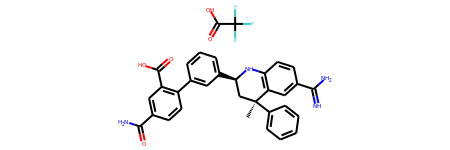

In [46]:
trans1_mols1 = Chem.MolFromSmiles(hh1.mols[0])
trans1_mols1

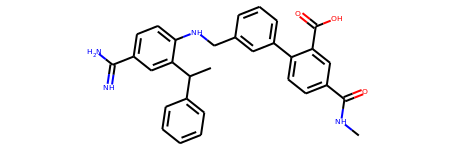

In [47]:
trans1_mols2 = Chem.MolFromSmiles(hh1.mols[1])
trans1_mols2

**可以看到这个分子以及和 init_state里的 分子不同了**

### 看看第2个变换 '[C:2]-,:[N:1]>>[N&H1:1]' ， 这个变换作用在第1号分子上

In [48]:
hh2 = hh1.transform("[C:2]-,:[N:1]>>[N&H1:1]", index=1)

transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol CNC(=O)c1ccc(-c2cccc([CH]Nc3ccc(cc3C(C)c3ccccc3)C(=N)N)c2)c(c1)C(=O)O


In [49]:
hh2.mols

['OC(=O)C(F)(F)F.C[C@@]1(C[C@H](NC2=C1C=C(C=C2)C(N)=N)C1=CC=CC(=C1)C1=C(C=C(C=C1)C(N)=O)C(O)=O)C1=CC=CC=C1',
 'CC(c1ccccc1)c1cc(ccc1N[CH]c1cccc(c1)-c1ccc(cc1C(=O)O)C([NH])=O)C(=N)N']

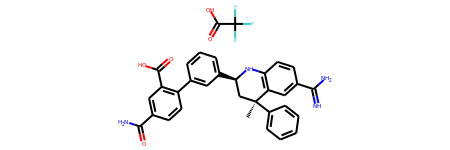

In [50]:
trans2_mols1 = Chem.MolFromSmiles(hh2.mols[0])
trans2_mols1

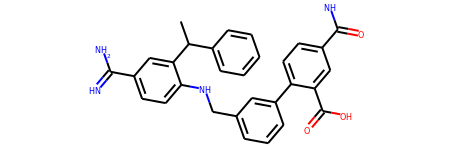

In [51]:
trans2_mols2 = Chem.MolFromSmiles(hh2.mols[1])
trans2_mols2

**可以看到这个分子以及和 init_state hh1 里的 分子不同了**

### 再来看看第3个变换 '[C:2]-,:[N:1]>>[N&H1:1]' ， 这个变换作用在第0号分子上 
### （omg 这个变换居然何上一个变换一毛一样， 但是作用在不同的分子上哦， 这回作用在0号分子上）

In [52]:
hh3 = hh2.transform("[C:2]-,:[N:1]>>[N&H1:1]", index=0)

transformation [C:2]-,:[N:1]>>[N&H1:1] target_mol OC(=O)C(F)(F)F.C[C@@]1(C[C@H](NC2=C1C=C(C=C2)C(N)=N)C1=CC=CC(=C1)C1=C(C=C(C=C1)C(N)=O)C(O)=O)C1=CC=CC=C1


In [54]:
hh3.mols

['CC(c1ccccc1)c1cc(ccc1N[CH]c1cccc(c1)-c1ccc(cc1C(=O)O)C([NH])=O)C(=N)N',
 'CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N']

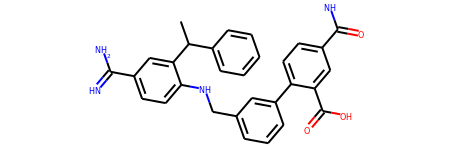

In [55]:
trans3_mols1 = Chem.MolFromSmiles(hh3.mols[0])
trans3_mols1

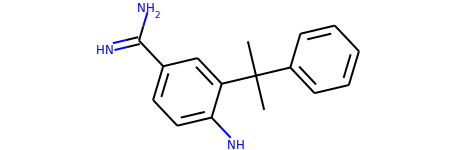

In [56]:
trans3_mols2 = Chem.MolFromSmiles(hh3.mols[1])
trans3_mols2

** 貌似被分解得原来越简单了，有木有**

### 来看看第4个变换 '[C:1]=[O:2]>>[C&H2:1]' ， 这个变换作用在第0号分子上 

In [57]:
hh4 = hh3.transform("[C:1]=[O:2]>>[C&H2:1]", index=0)

transformation [C:1]=[O:2]>>[C&H2:1] target_mol CC(c1ccccc1)c1cc(ccc1N[CH]c1cccc(c1)-c1ccc(cc1C(=O)O)C([NH])=O)C(=N)N


In [58]:
hh4.mols

['CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N',
 'CC(c1ccccc1)c1cc(ccc1N[CH]c1cccc(c1)-c1ccc(cc1C(=O)O)C[NH])C(=N)N']

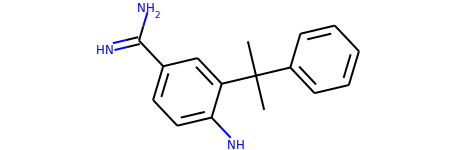

In [59]:
trans4_mols1 = Chem.MolFromSmiles(hh4.mols[0])
trans4_mols1

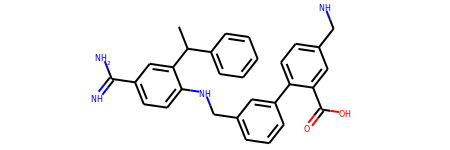

In [60]:
trans4_mols2 = Chem.MolFromSmiles(hh4.mols[1])
trans4_mols2

**不得不吐槽一下这个变换没卵用**

### 最后来看看第5个变换 '[C:1]=[O:2]>>[C&H2:1]' ， 这个变换作用在第0号分子上  （咦，好像与之前一样？）

In [61]:
hh5 = hh4.transform("[C:1]=[O:2]>>[C&H2:1]", index=0)

transformation [C:1]=[O:2]>>[C&H2:1] target_mol CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N


In [62]:
hh5.mols

['CC(C)(c1ccccc1)c1cc(ccc1[NH])C(=N)N',
 'CC(c1ccccc1)c1cc(ccc1N[CH]c1cccc(c1)-c1ccc(cc1C(=O)O)C[NH])C(=N)N']

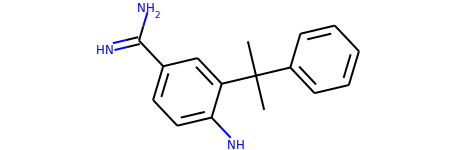

In [63]:
trans5_mols1 = Chem.MolFromSmiles(hh5.mols[0])
trans5_mols1

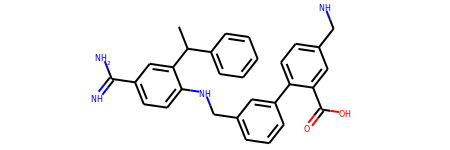

In [64]:
trans5_mols2 = Chem.MolFromSmiles(hh5.mols[1])
trans5_mols2

**好吧，果然何上一个变换一样，心态炸裂**

#### 但是不要慌，出现这种情况是正常的，加大树搜索深度应该可以解决，另外，一个好的building block mols 是需要的，我这里真的是不太会定义building block mols啊，大家学化学的来搞搞呀